In [53]:
import itertools
import time

from torch.onnx.ops import symbolic

from cirkit.backend.torch.circuits import TorchCircuit
from cirkit.symbolic.io import plot_circuit
from cirkit.templates import data_modalities, utils
from cirkit.pipeline import compile
from notebooks.datasets import sample_rings
import matplotlib.pyplot as plt
import torch
import numpy as np


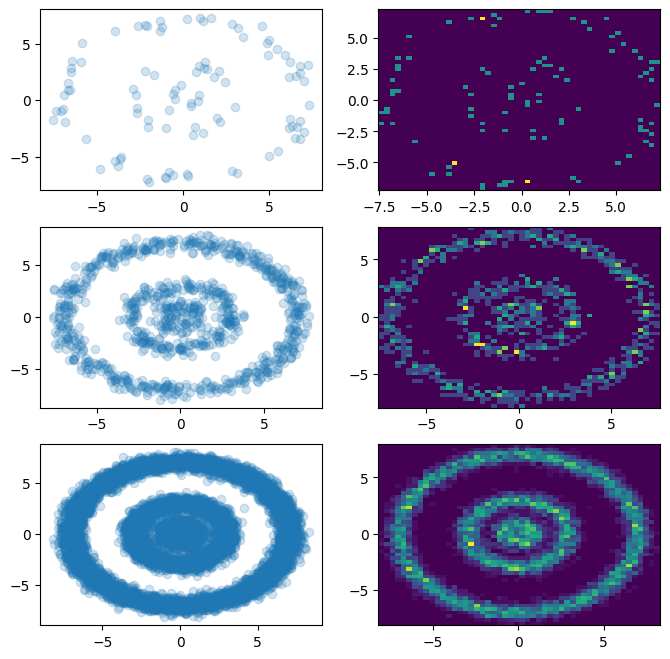

In [54]:
fig, rows = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
for (ax_scat, ax_hist), n in zip(rows, [100, 1_000, 10_000]):
    ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.4)
    ax_scat.scatter(ring_samples[:, 0], ring_samples[:, 1], alpha=0.2)
    ax_hist.hist2d(ring_samples[:, 0], ring_samples[:, 1], bins=(50, 50))

n = 10_000
ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.5)
ring_samples = np.float32(ring_samples)

In [55]:
from cirkit.pipeline import PipelineContext
from cirkit.symbolic.circuit import Circuit
from cirkit.utils.scope import Scope
from cirkit.symbolic.layers import GaussianLayer, HadamardLayer, SumLayer

device = torch.device("cpu")
def new_circuit():

    weight_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='uniform' # Initialize the sum weights by sampling from a standard normal distribution
    ))

    g0 = GaussianLayer(Scope((0,)), 2)
    g1 = GaussianLayer(Scope((1,)), 2)
    prod = HadamardLayer(num_input_units=2, arity=2)
    sl = SumLayer(2, 1, 1, weight_factory=weight_factory)

    symbolic_circuit = Circuit(
        layers=[g0, g1, prod, sl],
        in_layers={
            g0: [],
            g1: [],
            prod: [g0, g1],
            sl: [prod],
        },
        outputs=[sl]
    )
    pctx = PipelineContext(backend="torch", semiring="lse-sum", fold=True, optimize=False)
    circuit = compile(symbolic_circuit, pctx)
    circuit = circuit.to(device)
    return symbolic_circuit, circuit

symbolic_circuit, circuit = new_circuit()


Number of variables: 2
Structural properties:
 - Smoothness: True
 - Decomposability: True
 - Structured-decomposability: True
Number of layers: 3
Number of learnable parameters: 10



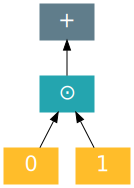

In [56]:
print(f"""
Number of variables: {symbolic_circuit.num_variables}
Structural properties:
 - Smoothness: {symbolic_circuit.is_smooth}
 - Decomposability: {symbolic_circuit.is_decomposable}
 - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}
Number of layers: {len(list(circuit.layers))}
Number of learnable parameters: {sum(p.numel() for p in circuit.parameters())}
""")
plot_circuit(symbolic_circuit)

In [57]:
# from torch import optim
#
# symbolic_circuit, circuit = new_circuit()
# optimizer = optim.Adam(circuit.parameters(), lr=0.01)
# LLs_fullbatch = []
# time_fullbatch = time.time()
# for epoch_idx in range(1000):
#     batch = ring_samples
#     batch = torch.from_numpy(batch).to(device)
#
#     log_likelihoods = circuit(batch)
#
#     loss = -torch.mean(log_likelihoods)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#
#     LLs_fullbatch.append(-loss.detach())
# time_fullbatch = time.time() - time_fullbatch
#
#
# symbolic_circuit, circuit = new_circuit()
# optimizer = optim.Adam(circuit.parameters(), lr=0.01)
# LLs_minibatch = []
# time_minibatch = time.time()
# for epoch_idx in range(100):
#     for i, batch in enumerate(np.vsplit(ring_samples, 10)):
#         batch = torch.from_numpy(batch).to(device)
#
#         log_likelihoods = circuit(batch)
#
#         loss = -torch.mean(log_likelihoods)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#         LLs_minibatch.append(-loss.detach())
# time_minibatch = time.time() - time_minibatch
#
# print(f"Full-batch time: {time_fullbatch * 1000:.0f}ms")
# print(f"Minibatch time: {time_minibatch * 1000:.0f}ms")
#
# plt.plot(np.arange(len(LLs_fullbatch)), LLs_fullbatch, label="Full-batch")
# plt.plot(np.arange(len(LLs_minibatch)), LLs_minibatch, label="Minibatch")
# plt.legend()
# plt.show()

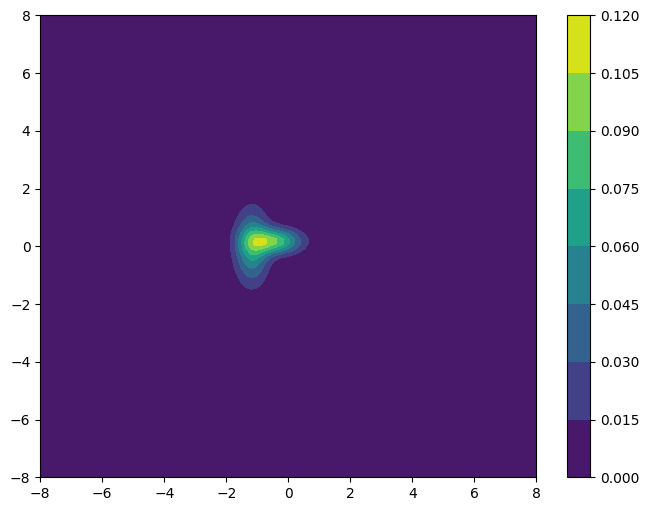

In [58]:
x = np.float32(np.linspace(-8, 8, 100))
y = np.float32(np.linspace(-8, 8, 100))

X, Y = np.meshgrid(x, y)

xy = itertools.product(x, y)
xy = torch.tensor(list(xy))
Z = circuit(xy).detach().exp().numpy().reshape(100, 100)

plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z)
plt.colorbar();

In [59]:
from cirkit.backend.torch.layers import TorchInnerLayer, TorchSumLayer


def print_tensor_stats(t):
    print(f"""
    n: {t.numel()}
    elems: {t}
""")

class FullBatchEM:
    def __init__(self, circuit):
        self.circuit = circuit
        self.inner_layer_params = {}
        self.inner_layer_inputs = {}
        self.inner_layer_outputs = {}
        for l in circuit.modules():
            if not isinstance(l, TorchSumLayer):
                continue
            self.inner_layer_params[l] = l.weight
            self.inner_layer_inputs[l] = None
            self.inner_layer_outputs[l] = None

    def _layer_fn(self, layer, *inputs):
        output = layer(*inputs)
        if isinstance(layer, TorchSumLayer):
            self.inner_layer_inputs[layer] = inputs
            self.inner_layer_outputs[layer] = output
            self.inner_layer_outputs[layer].retain_grad()
        return output

    def e_step(self, data):
        S_E = self.circuit.evaluate(data, module_fn=self._layer_fn)
        S_E = S_E.mean()
        S_E.backward()
        for l in self.inner_layer_outputs:
            with torch.no_grad():
                child_dim = 0

                outputs = self.inner_layer_outputs[l]
                outputs_grad = outputs.grad
                inputs = torch.stack(self.inner_layer_inputs[l], dim=child_dim)
                inputs_grad = inputs.grad
                weight_params = self.inner_layer_params[l]
                weights = weight_params()
                weight_grads = weights.grad


                print(f"{outputs.shape=} "
                      f"{inputs.shape=} "
                      f"{weights.shape=} "
                      f"{outputs_grad.shape=} ")

                n = torch.sum(
                    (1 / S_E) * outputs_grad * weights * inputs,
                    dim=[child_dim, 1]
                )
                n_update = n / n.sum()

                print(f"{weights=}")
                print(f"{n=}")
                print(f"{n_update=}")

                weight_params.outputs[0].update_params(n_update)

    def m_step(self):
        pass

em = FullBatchEM(circuit)
for i in range(10):
    # em.e_step(torch.from_numpy(ring_samples))
    em.e_step(torch.tensor([[1, 1]]))


outputs.shape=torch.Size([1, 1, 1]) inputs.shape=torch.Size([1, 1, 1, 1, 2]) weights.shape=torch.Size([1, 1, 2]) outputs_grad.shape=torch.Size([1, 1, 1]) 
weights=tensor([[[0.0939, 0.1333]]])
n=tensor([[[0.0701, 0.2599]]])
n_update=tensor([[[0.2125, 0.7875]]])
outputs.shape=torch.Size([1, 1, 1]) inputs.shape=torch.Size([1, 1, 1, 1, 2]) weights.shape=torch.Size([1, 1, 2]) outputs_grad.shape=torch.Size([1, 1, 1]) 
weights=tensor([[[0.2125, 0.7875]]])
n=tensor([[[0.1739, 1.6827]]])
n_update=tensor([[[0.0937, 0.9063]]])
outputs.shape=torch.Size([1, 1, 1]) inputs.shape=torch.Size([1, 1, 1, 1, 2]) weights.shape=torch.Size([1, 1, 2]) outputs_grad.shape=torch.Size([1, 1, 1]) 
weights=tensor([[[0.0937, 0.9063]]])
n=tensor([[[0.0700, 1.7669]]])
n_update=tensor([[[0.0381, 0.9619]]])
outputs.shape=torch.Size([1, 1, 1]) inputs.shape=torch.Size([1, 1, 1, 1, 2]) weights.shape=torch.Size([1, 1, 2]) outputs_grad.shape=torch.Size([1, 1, 1]) 
weights=tensor([[[0.0381, 0.9619]]])
n=tensor([[[0.0259, 1.710

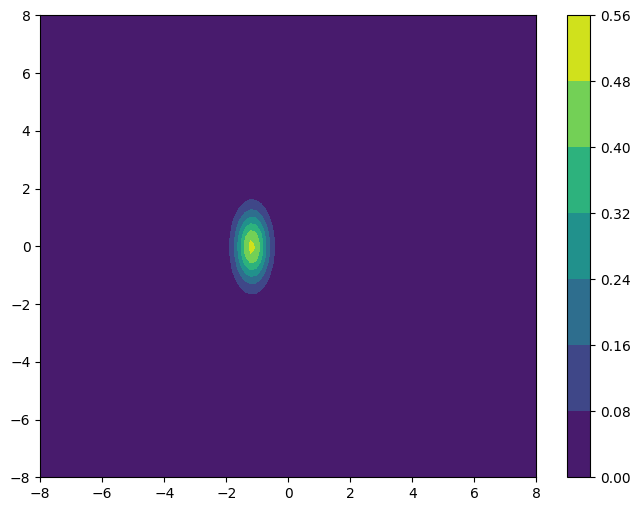

In [60]:
x = np.float32(np.linspace(-8, 8, 100))
y = np.float32(np.linspace(-8, 8, 100))

X, Y = np.meshgrid(x, y)

xy = itertools.product(x, y)
xy = torch.tensor(list(xy))
Z = circuit(xy).detach().exp().numpy().reshape(100, 100)

plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z)
plt.colorbar();